# Face Generation

In this project, a Generative Adversarial Network (GAN) will be defined and trained on a dataset of faces. The goal is to get a generator network to produce *new* images of faces that appear as realistic as possible.

The project will be divided into several tasks that involve **defining new architectures and training adversarial networks**. At the end of the notebook, the results of the trained generator can be visualized to see how well it performs. The generated samples should look like fairly realistic faces with only small amounts of noise.

### Getting the Data

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) will be used to train the adversarial networks. This dataset has higher resolution images than previous datasets used (such as MNIST or SVHN), so deeper networks will need to be defined and trained for a longer time to achieve good results. It is suggested to use a GPU for training.

### Pre-processed Data

Since the main focus of the project is on building the GANs, some of the pre-processing has already been done. Each of the CelebA images has been cropped to remove parts of the image that do not include a face, and then resized down to 64x64x3 NumPy images. 

> If working locally, the data can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip).

This is a zip file that needs to be extracted in the home directory of this notebook for further loading and processing. After extracting the data, there should be a directory of data named `processed-celeba-small/`.


In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import skimage.io as sk
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [3]:
# Set the directory where the data files are stored
data_dir = 'processed_celeba_small/celeba/'

# Use the glob function to retrieve a list of all files in the directory that end with '.jpg'
files = glob(os.path.join(data_dir, '*.jpg'))
print(len(files))

32600


## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) contains over 200,000 celebrity images with annotations. Since images are going to be generated, the annotations are not needed, only the images. It should be noted that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the main focus of the project is on building the GANs, some of the pre-processing has already been done. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This pre-processed dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images.

The first task is to build the dataloader. To do so, the following steps are required:
* implementing the get_transforms function
* creating a custom Dataset class that reads the CelebA data


### Implementation of the get_transforms function

The `get_transforms` function should output a `torchvision.transforms.Compose` of different transformations. The function takes a tuple of size as input and resizes the images to the input size. The output images should have values ranging from -1 to 1.


In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # Create a list of transforms to apply to the image
    transforms = [
        ToTensor(),  # Convert the image to a tensor
        Resize(size),  # Resize the image to the given size
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize the image using the given mean and standard deviation
    ]

    # Combine the transforms into a single transformation pipeline
    return Compose(transforms)

### Implementation of the DatasetDirectory class


The DatasetDirectory class is a torch Dataset that reads from the data directory. The __getitem__ method outputs a transformed tensor and the __len__ method outputs the number of files in the dataset. The class should be implemented in a manner that follows these requirements.

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # Set instance variables for the dataset
        self.directory = directory  # directory where images are stored
        self.transforms = transforms  # transform function to apply to the images
        self.extension = extension  # file format of the images

        # Get a list of all image files in the directory
        self.data = [os.path.join(self.directory, f) for f in os.listdir(self.directory) if f.endswith(self.extension)]

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.data)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # Load the image at the given index, and apply any specified transformations
        image_path = self.data[index]
        image = sk.imread(image_path)
        image = Image.fromarray(image)

        if self.transforms:
            image = self.transforms(image)
        
        return image

The functions below will aid in visualizing images from the dataset.

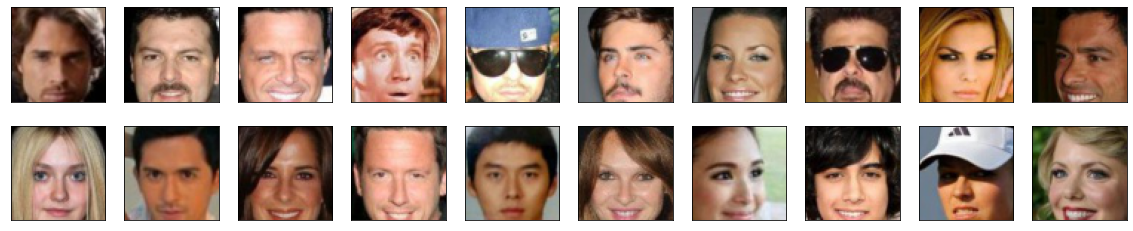

In [7]:
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As is known, a GAN is composed of two adversarial networks, a discriminator and a generator. With the working data pipeline, it is necessary to implement the discriminator and the generator. Any additional class or function can be implemented as needed.

### Implementation of the discriminator

The task of the discriminator is to evaluate the scores of real and fake images. Two constraints must be considered:

* the discriminator requires a **batch of 64x64x3 images** as input
* the output should be a single value that represents the score

Architectures such as DCGAN, WGAN-GP, or DRAGAN can serve as inspiration to create the discriminator. Here are some tips:

#### Some tips
*To scale down from the input image, `Conv2d` layers with the correct hyperparameters or Pooling layers can be used.
*If the gradient penalty is used, Batch Normalization layers should not be included in the discriminator.


In [8]:
from torch import nn
from torch.nn import Module

In [79]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        init_feature_maps = 64
        kernel_size = 4
        stride = 2
        padding = 1
        bias = False
        
        self.main = nn.Sequential(
            
            # Input Layer
            nn.Conv2d(in_channels=3,
                      out_channels=init_feature_maps,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second Layer
            nn.Conv2d(in_channels=init_feature_maps,
                      out_channels=init_feature_maps*2,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(num_features=init_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # Third Layer
            nn.Conv2d(in_channels=init_feature_maps*2,
                      out_channels=init_feature_maps*4,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(num_features=init_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # Fourth Layer
            nn.Conv2d(in_channels=init_feature_maps*4,
                      out_channels=init_feature_maps*8,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(num_features=init_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # Fifth Layer
            nn.Conv2d(in_channels=init_feature_maps*8,
                      out_channels=1,
                      kernel_size=kernel_size, stride=1, padding=0, bias=bias),
            nn.Sigmoid()
        )

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)

In [ ]:
discriminator = Discriminator()

### Implementation of the generator

The main responsibility of the generator is to create "fake images" and learn the dataset distribution. Three constraints need to be taken into account while creating the generator:

* The generator requires a vector of dimensions `[batch_size, latent_dimension, 1, 1]` as input.
* The generator should produce **64x64x3** images as output.

Inspiration can be drawn from various architectures such as DCGAN, WGAN-GP, or DRAGAN to create the generator. Here are some tips:

* To scale up from the latent vector input, `ConvTranspose2d` layers can be used.
* The usage of **Batch Normalization** often helps with training, especially in GANs.

In [81]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        init_feature_maps = 64
        kernel_size = 4
        stride = 2 
        padding = 1
        bias = False
        
        self.main = nn.Sequential(
            # Input Layer
            nn.ConvTranspose2d(in_channels=latent_dim,
                               out_channels=init_feature_maps * 8,
                               kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(init_feature_maps * 8),
            nn.ReLU(True),
            
            # Second Layer
            nn.ConvTranspose2d(in_channels=init_feature_maps * 8,
                               out_channels=init_feature_maps * 4,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(init_feature_maps * 4),
            nn.ReLU(True),
            
            # Third Layer
            nn.ConvTranspose2d(in_channels=init_feature_maps * 4,
                               out_channels=init_feature_maps * 2,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(init_feature_maps * 2),
            nn.ReLU(True),
            
            #Fourth Layer
            nn.ConvTranspose2d(in_channels=init_feature_maps * 2,
                               out_channels=init_feature_maps * 1,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(init_feature_maps * 1),
            nn.ReLU(True),
            
            # Output Layer (Image 3 channels)
            nn.ConvTranspose2d(in_channels=init_feature_maps * 1,
                               out_channels=3,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.Tanh()
        )
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)

In [ ]:
latent_dim = 128
generator = Generator(latent_dim)

## Optimizer

In the subsequent section, optimizers are created for the generator and discriminator. One might need to experiment with various optimizers, learning rates, and other hyperparameters, as they can have a significant impact on the output quality.

### Implementation of the optimizers

In [83]:
import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module):
    """ This function return the optimizers of the generator and the discriminator """
    lr = 0.0005
    beta1 = 0.5
    beta2 = 0.999
    
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    
    return g_optimizer, d_optimizer

## Losses implementation

This section deals with the implementation of the loss function for the generator and discriminator. Experimentation with different loss functions is encouraged.
Here are some tips:

* The commonly used binary cross-entropy loss can be selected or other losses discussed in the course, such as the Wasserstein distance.
* A gradient penalty function can be implemented, as discussed in the course. Although it is not required, the code will work with or without it.

### Implementation of the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [84]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    L = torch.nn.BCELoss()
    labels = torch.zeros(fake_logits.size()[0], 1).to(device)
    target_ones = torch.full((batch_size,1,1,1), 1, device=device,dtype=torch.float)
    
    # calculate loss
    loss = L(fake_logits, target_ones)
    return loss

### Implementation of the discriminator loss

The objective is to design the discriminator loss function in a way that the discriminator assigns high scores to real images and low scores to fake images. The discriminator loss must reflect this goal.

In [85]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    
    ## Real losses
    L = torch.nn.BCELoss()
    target_ones = torch.ones((batch_size, 1,1,1), device=device)
    target_zeros = torch.zeros((batch_size, 1,1,1), device=device)
    
    loss_real = L(real_logits, target_ones)
    loss_real.backward()
     
    ## Fake losses
    D_x = real_logits.mean().item()
    loss_fake = L(fake_logits, target_zeros)
    loss_fake.backward()
    D_G_z1 = loss_fake.mean().item()
    
    loss = (loss_real + loss_fake)
    return loss

## Training


The training process involves training the discriminator and the generator alternatively. The real_loss and fake_loss functions can be used to calculate the discriminator losses.

Here are the steps to follow for the training process:

* The discriminator should be trained by alternating between real and fake images.
* Next, the generator should be trained to trick the discriminator by using an opposing loss function.

### Implementation of the generator step and the discriminator step functions

The following functions need to be implemented:

* generator step
* discriminator step

Each function must perform the following steps:

* Calculate the loss
* Backpropagate the gradient
* Perform one optimizer step.

In [87]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    
    # Generate fake images
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device,dtype=torch.float)
    fake_samples = generator(noise)
    generator.zero_grad()
    
    # Compute the discriminator losses on fake images 
    # using flipped labels!
    fake_images = discriminator(fake_samples)
    g_loss = generator_loss(fake_images) # use real loss to flip labels
    
    # perform backprop
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}

criterion = torch.nn.BCELoss()
noise_fn = lambda x: torch.randn((x, latent_dim,4,4), device=device)

def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
  
    discriminator.zero_grad()
    target_ones = torch.ones((batch_size, 1), device=device) #torch.full((batch_size,), 1, device=device)
    
    # Compute the discriminator losses on fake images 
    pred_real = discriminator(real_images)    
    
    # Generate fake images
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device,dtype=torch.float)
    fake_samples = generator(noise)
    target_zeroes = torch.full((batch_size,), 1, device=device,dtype=torch.float)
    pred_fake = discriminator(fake_samples.detach())
    
    d_loss = discriminator_loss(pred_real,pred_fake)
    d_optimizer.step()
    
    gp=0
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

The main training loop is already implemented. However, different hyperparameters can be experimented with to enhance the model's performance.

In [88]:
from datetime import datetime

In [89]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

In [90]:
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [91]:
def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Implementation of the training strategy


Different training strategies can be experimented with to improve the performance of the model. For instance:

* Training the generator more often than the discriminator can result in more stable and realistic image generation. This can be achieved by changing the order of the training steps in the main training loop.
* Adding noise to the input image can help the model learn to generate more robust and varied images. One way to achieve this is by adding a small amount of random noise to the input images.
* Label smoothing can be used to regularize the model and prevent overfitting. This involves replacing the binary labels of 0 and 1 with smoothed values such as 0.1 and 0.9, respectively.

2023-01-24 12:52:45 | Epoch [1/10] | Batch 0/509 | d_loss: 1.4833 | g_loss: 5.6960
2023-01-24 12:52:57 | Epoch [1/10] | Batch 50/509 | d_loss: 4.9808 | g_loss: 6.6676
2023-01-24 12:53:08 | Epoch [1/10] | Batch 100/509 | d_loss: 0.6759 | g_loss: 2.2135
2023-01-24 12:53:20 | Epoch [1/10] | Batch 150/509 | d_loss: 0.3078 | g_loss: 2.4410
2023-01-24 12:53:32 | Epoch [1/10] | Batch 200/509 | d_loss: 1.1100 | g_loss: 1.7732
2023-01-24 12:53:43 | Epoch [1/10] | Batch 250/509 | d_loss: 0.2838 | g_loss: 4.0450
2023-01-24 12:53:55 | Epoch [1/10] | Batch 300/509 | d_loss: 0.5277 | g_loss: 3.0715
2023-01-24 12:54:07 | Epoch [1/10] | Batch 350/509 | d_loss: 0.6617 | g_loss: 3.4693
2023-01-24 12:54:18 | Epoch [1/10] | Batch 400/509 | d_loss: 0.3656 | g_loss: 2.5294
2023-01-24 12:54:30 | Epoch [1/10] | Batch 450/509 | d_loss: 1.5070 | g_loss: 7.2104
2023-01-24 12:54:42 | Epoch [1/10] | Batch 500/509 | d_loss: 0.5182 | g_loss: 2.7259


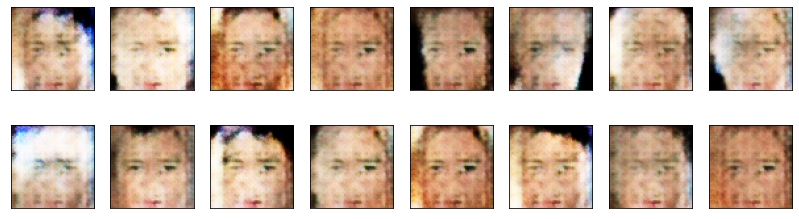

2023-01-24 12:54:45 | Epoch [2/10] | Batch 0/509 | d_loss: 0.7105 | g_loss: 2.9137
2023-01-24 12:54:56 | Epoch [2/10] | Batch 50/509 | d_loss: 0.5803 | g_loss: 2.0428
2023-01-24 12:55:08 | Epoch [2/10] | Batch 100/509 | d_loss: 0.4175 | g_loss: 1.6982
2023-01-24 12:55:20 | Epoch [2/10] | Batch 150/509 | d_loss: 0.8270 | g_loss: 2.0776
2023-01-24 12:55:31 | Epoch [2/10] | Batch 200/509 | d_loss: 0.4140 | g_loss: 2.2243
2023-01-24 12:55:43 | Epoch [2/10] | Batch 250/509 | d_loss: 0.8544 | g_loss: 2.3050
2023-01-24 12:55:55 | Epoch [2/10] | Batch 300/509 | d_loss: 0.4755 | g_loss: 4.2776
2023-01-24 12:56:06 | Epoch [2/10] | Batch 350/509 | d_loss: 0.5493 | g_loss: 2.3381
2023-01-24 12:56:18 | Epoch [2/10] | Batch 400/509 | d_loss: 0.3285 | g_loss: 3.7432
2023-01-24 12:56:29 | Epoch [2/10] | Batch 450/509 | d_loss: 1.7990 | g_loss: 5.2531
2023-01-24 12:56:41 | Epoch [2/10] | Batch 500/509 | d_loss: 1.1812 | g_loss: 4.3523


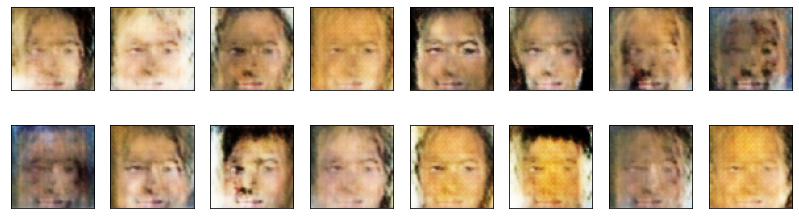

2023-01-24 12:56:44 | Epoch [3/10] | Batch 0/509 | d_loss: 0.7206 | g_loss: 2.9412
2023-01-24 12:56:56 | Epoch [3/10] | Batch 50/509 | d_loss: 0.5198 | g_loss: 3.1129
2023-01-24 12:57:08 | Epoch [3/10] | Batch 100/509 | d_loss: 0.2810 | g_loss: 3.2166
2023-01-24 12:57:19 | Epoch [3/10] | Batch 150/509 | d_loss: 0.4616 | g_loss: 4.3486
2023-01-24 12:57:31 | Epoch [3/10] | Batch 200/509 | d_loss: 1.2881 | g_loss: 6.1169
2023-01-24 12:57:43 | Epoch [3/10] | Batch 250/509 | d_loss: 0.4117 | g_loss: 3.0840
2023-01-24 12:57:54 | Epoch [3/10] | Batch 300/509 | d_loss: 0.6630 | g_loss: 3.6461
2023-01-24 12:58:06 | Epoch [3/10] | Batch 350/509 | d_loss: 1.4287 | g_loss: 5.8571
2023-01-24 12:58:18 | Epoch [3/10] | Batch 400/509 | d_loss: 0.3566 | g_loss: 3.6495
2023-01-24 12:58:30 | Epoch [3/10] | Batch 450/509 | d_loss: 0.9011 | g_loss: 4.1267
2023-01-24 12:58:41 | Epoch [3/10] | Batch 500/509 | d_loss: 0.9914 | g_loss: 5.3170


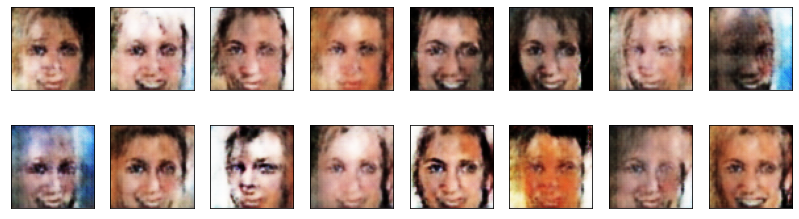

2023-01-24 12:58:45 | Epoch [4/10] | Batch 0/509 | d_loss: 0.6419 | g_loss: 5.3649
2023-01-24 12:58:56 | Epoch [4/10] | Batch 50/509 | d_loss: 0.5514 | g_loss: 3.6457
2023-01-24 12:59:08 | Epoch [4/10] | Batch 100/509 | d_loss: 0.5556 | g_loss: 4.6770
2023-01-24 12:59:19 | Epoch [4/10] | Batch 150/509 | d_loss: 0.4316 | g_loss: 3.8570
2023-01-24 12:59:31 | Epoch [4/10] | Batch 200/509 | d_loss: 0.3871 | g_loss: 5.2815
2023-01-24 12:59:43 | Epoch [4/10] | Batch 250/509 | d_loss: 0.3068 | g_loss: 2.5237
2023-01-24 12:59:54 | Epoch [4/10] | Batch 300/509 | d_loss: 0.4414 | g_loss: 2.4484
2023-01-24 13:00:06 | Epoch [4/10] | Batch 350/509 | d_loss: 0.5093 | g_loss: 4.3553
2023-01-24 13:00:18 | Epoch [4/10] | Batch 400/509 | d_loss: 0.5775 | g_loss: 1.8718
2023-01-24 13:00:29 | Epoch [4/10] | Batch 450/509 | d_loss: 2.2758 | g_loss: 1.2825
2023-01-24 13:00:41 | Epoch [4/10] | Batch 500/509 | d_loss: 0.4138 | g_loss: 5.4157


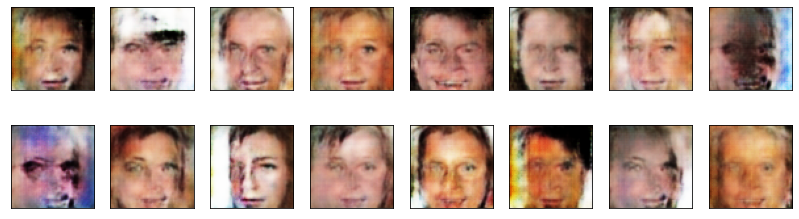

2023-01-24 13:00:44 | Epoch [5/10] | Batch 0/509 | d_loss: 0.1836 | g_loss: 3.9280
2023-01-24 13:00:56 | Epoch [5/10] | Batch 50/509 | d_loss: 0.4398 | g_loss: 5.0311
2023-01-24 13:01:07 | Epoch [5/10] | Batch 100/509 | d_loss: 0.5311 | g_loss: 5.6627
2023-01-24 13:01:19 | Epoch [5/10] | Batch 150/509 | d_loss: 0.3585 | g_loss: 4.1098
2023-01-24 13:01:31 | Epoch [5/10] | Batch 200/509 | d_loss: 0.1920 | g_loss: 4.1186
2023-01-24 13:01:42 | Epoch [5/10] | Batch 250/509 | d_loss: 0.1628 | g_loss: 3.7752
2023-01-24 13:01:54 | Epoch [5/10] | Batch 300/509 | d_loss: 0.1816 | g_loss: 5.8466
2023-01-24 13:02:06 | Epoch [5/10] | Batch 350/509 | d_loss: 0.2562 | g_loss: 4.6378
2023-01-24 13:02:18 | Epoch [5/10] | Batch 400/509 | d_loss: 0.4523 | g_loss: 5.5495
2023-01-24 13:02:29 | Epoch [5/10] | Batch 450/509 | d_loss: 0.3947 | g_loss: 8.7099
2023-01-24 13:02:41 | Epoch [5/10] | Batch 500/509 | d_loss: 1.8213 | g_loss: 4.8632


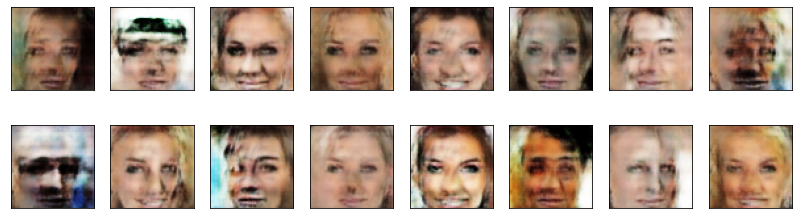

2023-01-24 13:02:44 | Epoch [6/10] | Batch 0/509 | d_loss: 0.4463 | g_loss: 3.3653
2023-01-24 13:02:56 | Epoch [6/10] | Batch 50/509 | d_loss: 0.4192 | g_loss: 5.6168
2023-01-24 13:03:08 | Epoch [6/10] | Batch 100/509 | d_loss: 0.6934 | g_loss: 7.3670
2023-01-24 13:03:19 | Epoch [6/10] | Batch 150/509 | d_loss: 0.3479 | g_loss: 4.3777
2023-01-24 13:03:31 | Epoch [6/10] | Batch 200/509 | d_loss: 0.8250 | g_loss: 7.6177
2023-01-24 13:03:42 | Epoch [6/10] | Batch 250/509 | d_loss: 0.1534 | g_loss: 4.1883
2023-01-24 13:03:54 | Epoch [6/10] | Batch 300/509 | d_loss: 0.3595 | g_loss: 4.4985
2023-01-24 13:04:06 | Epoch [6/10] | Batch 350/509 | d_loss: 0.2924 | g_loss: 5.1300
2023-01-24 13:04:17 | Epoch [6/10] | Batch 400/509 | d_loss: 0.2044 | g_loss: 3.3709
2023-01-24 13:04:29 | Epoch [6/10] | Batch 450/509 | d_loss: 0.5597 | g_loss: 7.9137
2023-01-24 13:04:41 | Epoch [6/10] | Batch 500/509 | d_loss: 0.4694 | g_loss: 6.7072


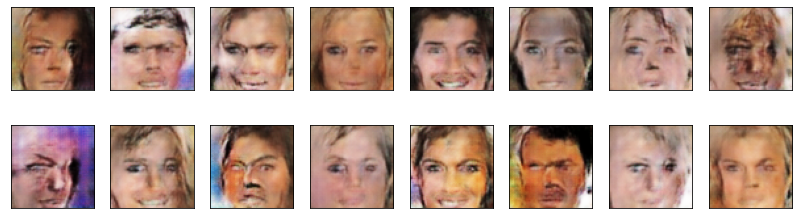

2023-01-24 13:04:44 | Epoch [7/10] | Batch 0/509 | d_loss: 0.3414 | g_loss: 5.3264
2023-01-24 13:04:55 | Epoch [7/10] | Batch 50/509 | d_loss: 0.2135 | g_loss: 2.1835
2023-01-24 13:05:07 | Epoch [7/10] | Batch 100/509 | d_loss: 0.1810 | g_loss: 3.8482
2023-01-24 13:05:19 | Epoch [7/10] | Batch 150/509 | d_loss: 0.8614 | g_loss: 8.6828
2023-01-24 13:05:30 | Epoch [7/10] | Batch 200/509 | d_loss: 0.2468 | g_loss: 5.7463
2023-01-24 13:05:42 | Epoch [7/10] | Batch 250/509 | d_loss: 1.6217 | g_loss: 9.1299
2023-01-24 13:05:54 | Epoch [7/10] | Batch 300/509 | d_loss: 0.6826 | g_loss: 2.0853
2023-01-24 13:06:06 | Epoch [7/10] | Batch 350/509 | d_loss: 0.2606 | g_loss: 4.6401
2023-01-24 13:06:17 | Epoch [7/10] | Batch 400/509 | d_loss: 0.3820 | g_loss: 4.0132
2023-01-24 13:06:29 | Epoch [7/10] | Batch 450/509 | d_loss: 0.3174 | g_loss: 3.8691
2023-01-24 13:06:41 | Epoch [7/10] | Batch 500/509 | d_loss: 0.3094 | g_loss: 4.0641


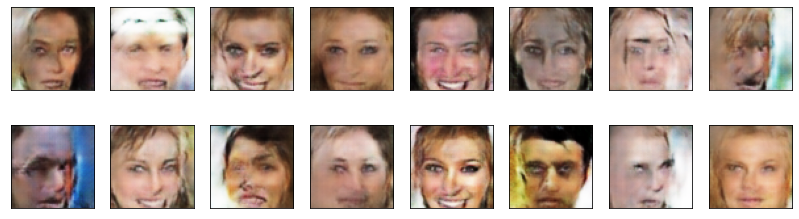

2023-01-24 13:06:44 | Epoch [8/10] | Batch 0/509 | d_loss: 1.6169 | g_loss: 4.5120
2023-01-24 13:06:56 | Epoch [8/10] | Batch 50/509 | d_loss: 0.3639 | g_loss: 5.1663
2023-01-24 13:07:07 | Epoch [8/10] | Batch 100/509 | d_loss: 0.2516 | g_loss: 4.4379
2023-01-24 13:07:19 | Epoch [8/10] | Batch 150/509 | d_loss: 0.2202 | g_loss: 5.6481
2023-01-24 13:07:31 | Epoch [8/10] | Batch 200/509 | d_loss: 0.1453 | g_loss: 4.6038
2023-01-24 13:07:42 | Epoch [8/10] | Batch 250/509 | d_loss: 0.3786 | g_loss: 4.1134
2023-01-24 13:07:54 | Epoch [8/10] | Batch 300/509 | d_loss: 0.5518 | g_loss: 3.5179
2023-01-24 13:08:05 | Epoch [8/10] | Batch 350/509 | d_loss: 0.9174 | g_loss: 7.4656
2023-01-24 13:08:17 | Epoch [8/10] | Batch 400/509 | d_loss: 0.1178 | g_loss: 4.9281
2023-01-24 13:08:29 | Epoch [8/10] | Batch 450/509 | d_loss: 0.3831 | g_loss: 4.7512
2023-01-24 13:08:40 | Epoch [8/10] | Batch 500/509 | d_loss: 0.1007 | g_loss: 3.3577


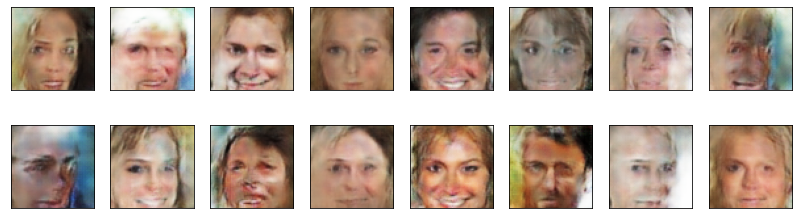

2023-01-24 13:08:43 | Epoch [9/10] | Batch 0/509 | d_loss: 0.0774 | g_loss: 5.0560
2023-01-24 13:08:55 | Epoch [9/10] | Batch 50/509 | d_loss: 0.3316 | g_loss: 5.7335
2023-01-24 13:09:07 | Epoch [9/10] | Batch 100/509 | d_loss: 0.4323 | g_loss: 6.2503
2023-01-24 13:09:19 | Epoch [9/10] | Batch 150/509 | d_loss: 0.2432 | g_loss: 5.8950
2023-01-24 13:09:30 | Epoch [9/10] | Batch 200/509 | d_loss: 0.3919 | g_loss: 6.0711
2023-01-24 13:09:42 | Epoch [9/10] | Batch 250/509 | d_loss: 0.6366 | g_loss: 2.9442
2023-01-24 13:09:54 | Epoch [9/10] | Batch 300/509 | d_loss: 0.1283 | g_loss: 5.2330
2023-01-24 13:10:05 | Epoch [9/10] | Batch 350/509 | d_loss: 0.1508 | g_loss: 4.5576
2023-01-24 13:10:17 | Epoch [9/10] | Batch 400/509 | d_loss: 0.5050 | g_loss: 4.1719
2023-01-24 13:10:29 | Epoch [9/10] | Batch 450/509 | d_loss: 0.1966 | g_loss: 5.1379
2023-01-24 13:10:40 | Epoch [9/10] | Batch 500/509 | d_loss: 0.7273 | g_loss: 4.5970


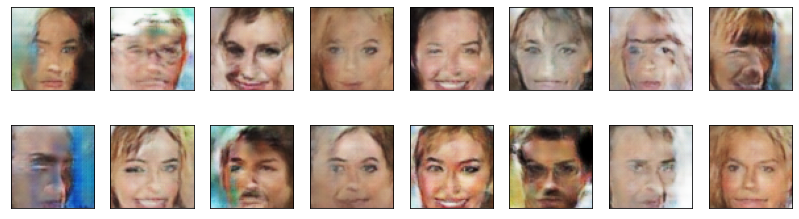

2023-01-24 13:10:44 | Epoch [10/10] | Batch 0/509 | d_loss: 0.7806 | g_loss: 4.8039
2023-01-24 13:10:55 | Epoch [10/10] | Batch 50/509 | d_loss: 0.4584 | g_loss: 4.8879
2023-01-24 13:11:07 | Epoch [10/10] | Batch 100/509 | d_loss: 1.0078 | g_loss: 9.0836
2023-01-24 13:11:19 | Epoch [10/10] | Batch 150/509 | d_loss: 0.5443 | g_loss: 4.5032
2023-01-24 13:11:30 | Epoch [10/10] | Batch 200/509 | d_loss: 0.3393 | g_loss: 5.3927
2023-01-24 13:11:42 | Epoch [10/10] | Batch 250/509 | d_loss: 0.4201 | g_loss: 4.0756
2023-01-24 13:11:54 | Epoch [10/10] | Batch 300/509 | d_loss: 0.2707 | g_loss: 5.0432
2023-01-24 13:12:05 | Epoch [10/10] | Batch 350/509 | d_loss: 2.3024 | g_loss: 10.5341
2023-01-24 13:12:17 | Epoch [10/10] | Batch 400/509 | d_loss: 0.9276 | g_loss: 7.4517
2023-01-24 13:12:29 | Epoch [10/10] | Batch 450/509 | d_loss: 0.3787 | g_loss: 4.1510
2023-01-24 13:12:40 | Epoch [10/10] | Batch 500/509 | d_loss: 1.0016 | g_loss: 3.3458


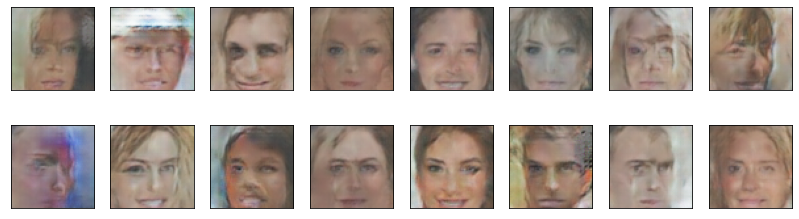

In [92]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
               
        batch_size = real_images.size(0)
        
        ###### DISCRIMINATOR ######
        d_optimizer.zero_grad()
        # Train on Real images and compute the discriminator loss
        real_images = real_images.cuda()
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
      
        ##### GENERATOR ######
        g_optimizer.zero_grad()
        g_loss = generator_step(batch_size, latent_dim)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

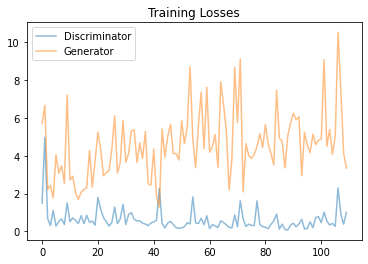

In [93]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Conclusion

In conclusion, it was observed that the model has the capability to generate primary facial features such as hair, eyes, nose, and mouth, but the generated images are abstract and appear artificial. The limitation of the dataset, which consists only of images of white people, could be a reason for this lack of variability. Moreover, the low resolution of the images after the preprocessing affected the quality of the generated images. 
To enhance the project, future work could involve using higher resolution input images, modifying the generator and discriminator architecture, possibly using a pre-trained model like VGG, and experimenting with Wasserstain loss (WGAN) and gradient penalties to overcome issues with mode collapse and vanishing gradients. Finally, the implementation of advanced architectures such as StyleGAN or ProGAN could be explored to create realistic, high-resolution images.

